In [1]:
import sys
sys.path.append('..')

import numpy as np
import cirq
import mitiq
from cirq.contrib.qasm_import import circuit_from_qasm
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from functools import partial
from tqdm import tqdm
import sympy as sp
import json
import pickle

import mosaic

**construct the ideal circuit**

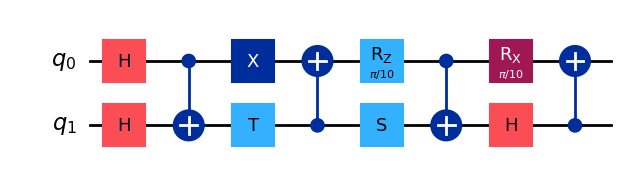

In [2]:
qubits = cirq.LineQubit.range(2)
circ = cirq.Circuit([
    cirq.H(qubits[0]),
    cirq.H(qubits[1]),
    cirq.CNOT(qubits[0], qubits[1]),
    cirq.X.on(qubits[0]),
    cirq.T.on(qubits[1]),
    cirq.CNOT(qubits[1], qubits[0]),
    cirq.ZPowGate(exponent=0.1).on(qubits[0]),
    cirq.S.on(qubits[1]),
    cirq.CNOT(qubits[0], qubits[1]),
    cirq.XPowGate(exponent=0.1).on(qubits[0]),
    cirq.H.on(qubits[1]),
    cirq.CNOT(qubits[1], qubits[0]),
])
# circ = cirq.Circuit([  # only involves 2-qubit gates
#     cirq.XXPowGate(exponent=0.1).on(qubits[0], qubits[1]),
#     cirq.Rz(rads=0.2).on(qubits[1]).controlled_by(qubits[0]),
#     cirq.YYPowGate(exponent=0.1).on(qubits[0], qubits[1]),
#     cirq.Rx(rads=0.1).on(qubits[0]).controlled_by(qubits[1]),
#     cirq.ZZPowGate(exponent=0.1).on(qubits[0], qubits[1]),
# ])
QuantumCircuit.from_qasm_str(circ.to_qasm()).draw('mpl', filename='circ_2q.pdf')

In [3]:
init_state = np.array([
    [1, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
]).astype(complex)
final_state = circ.unitary() @ init_state @ circ.unitary().conj().T
prob_11 = final_state[1, 1].real
prob_11

0.46753024329587667

In [4]:
final_state.round(3)

array([[ 0.08 +0.j   , -0.109-0.16j ,  0.07 -0.022j,  0.052+0.168j],
       [-0.109+0.16j ,  0.468+0.j   , -0.052+0.168j, -0.406-0.125j],
       [ 0.07 +0.022j, -0.052-0.168j,  0.066+0.j   ,  0.   +0.16j ],
       [ 0.052-0.168j, -0.406+0.125j,  0.   -0.16j ,  0.386+0.j   ]])

In [5]:
n = len(qubits)
p_cirq = 0.01
p = 4**n / (4**n - 1) * p_cirq
print(f'p_cirq = {p_cirq}, p = {p}')

p_cirq = 0.01, p = 0.010666666666666666


In [6]:
circ_noise_interleaved = cirq.Circuit()
for g in circ.all_operations():
    circ_noise_interleaved.append(g)
    circ_noise_interleaved.append(cirq.depolarize(p_cirq, 2).on(*qubits))
circ_noise_interleaved

0: ───H───D(0.01)───────D(0.01)───@───D(0.01)───X───D(0.01)───────D(0.01)───X───D(0.01)───Z^0.1───D(0.01)───────D(0.01)───@───D(0.01)───X^0.1───D(0.01)───────D(0.01)───X───D(0.01)───
          │             │         │   │             │             │         │   │                 │             │         │   │                 │             │         │   │
1: ───────#2────────H───#2────────X───#2────────────#2────────T───#2────────@───#2────────────────#2────────S───#2────────X───#2────────────────#2────────H───#2────────@───#2────────

In [7]:
r = mosaic.circuits.num_gates(circ)
p_r = 1 - (1 - p)**r
p_r_cirq = p_r * (4**n - 1) / 4**n
print(f'p_r_cirq = {p_r_cirq}, p_r = {p_r}')
circ_noise = circ.copy()
circ_noise.append(cirq.depolarize(p_r_cirq, 2).on(*qubits))
circ_noise

p_r_cirq = 0.11320440490756703, p = 0.12075136523473817


0: ───H───@───X───X───Z^0.1───@───X^0.1───X───D(0.113)───
          │       │           │           │   │
1: ───H───X───T───@───S───────X───H───────@───#2─────────

**noisy simulation comparison**

In [8]:
sim = cirq.DensityMatrixSimulator()

rho1 = sim.simulate(circ_noise_interleaved).final_density_matrix
rho2 = sim.simulate(circ_noise).final_density_matrix

assert np.allclose(rho1, rho2, atol=1e-5), "rho1 and rho2 should be equal!"

**append inverse channel to `circ_noise`**

In [9]:
circ_noise

0: ───H───@───X───X───Z^0.1───@───X^0.1───X───D(0.113)───
          │       │           │           │   │
1: ───H───X───T───@───S───────X───H───────@───#2─────────

In [10]:
final_state_noise = cirq.DensityMatrixSimulator().simulate(circ_noise).final_density_matrix
prob_11_noise = final_state_noise[1, 1].real
print('disparity = ', prob_11_noise - prob_11)

disparity =  -0.02626713385030477


**Testing our error mitigation approach**:

- baseline: conventional PEC method
- baseline: linear combination of two noisy channels: $\mathcal{E}^{-1} = \eta_1\mathcal{E}_1 - \eta_2\mathcal{E}_2$ in which both $\mathcal{E}_1$ and $\mathcal{E}_2$ are depolarizing channels (CPTP)
- our end-to-end PEC method: get the expression of $\mathcal{R}$ as linear combination of Paulis, then sampling noisy Paulis cause ideal Paulis is further linear combinations of noisy Paulis

In [11]:
# baseline: conventional PEC

# def execute(circ: cirq.Circuit):
#     return cirq.DensityMatrixSimulator().simulate(circ).final_density_matrix[1,1].real

def execute_noisy(circ: cirq.Circuit, p_cirq):
    n = cirq.num_qubits(circ)
    p = 4**n / (4**n - 1) * p_cirq
    p_r = 1 - (1 - p)**r
    p_r_cirq = p_r * (4**n - 1) / 4**n
    qubits = list(circ.all_qubits())
    circ_noise = circ.copy()
    circ_noise.append(cirq.depolarize(p_r_cirq, 2).on(*qubits))
    return cirq.DensityMatrixSimulator().simulate(circ_noise).final_density_matrix[1,1].real

def execute_noise_interleaved(circ: cirq.Circuit, p_cirq):
    circ_noise_interleaved = cirq.Circuit()
    for moment in circ:
        circ_noise_interleaved.append(moment)
        circ_noise_interleaved.append(cirq.depolarize(p_cirq, 2).on(*qubits))
    return cirq.DensityMatrixSimulator().simulate(circ_noise_interleaved).final_density_matrix[1,1].real


In [12]:
rates_cirq = np.linspace(0, 0.1, 11)
noisy_vals = [execute_noisy(circ, p_cirq) for p_cirq in rates_cirq]
np.save('circ_2q-noisy_vals.npy', noisy_vals)

In [13]:
reps = mitiq.pec.represent_operations_in_circuit_with_global_depolarizing_noise(circ, p)
mitiq.pec.execute_with_pec(circ, partial(execute_noisy, p_cirq=p_cirq), representations=reps, random_state=42)

0.46219406721862955

baseline: conventional PEC method

In [186]:
pec_vals = []
pec_datas = []
for p_cirq in tqdm(rates_cirq):
    reps = mitiq.pec.represent_operations_in_circuit_with_global_depolarizing_noise(circ, p_cirq)
    pec_val, pec_data = mitiq.pec.execute_with_pec(circ, partial(execute_noisy, p_cirq=p_cirq), representations=reps, random_state=42, full_output=True)
    pec_vals.append(pec_val)
    pec_datas.append(pec_data)

 91%|█████████ | 10/11 [17:43<03:45, 225.80s/it]/Users/jack/opt/miniconda3/lib/python3.8/site-packages/mitiq/pec/pec.py:123: LargeSampleWarning: The number of PEC samples is very large. It may take several minutes. It may be necessary to reduce 'precision' or 'num_samples'.
  warnings.warn(_LARGE_SAMPLE_WARN, LargeSampleWarning)
100%|██████████| 11/11 [30:05<00:00, 164.18s/it]


In [197]:
sampling_complexities_pec = [data['num_samples'] for data in pec_datas]
print(sampling_complexities_pec)

[1111, 1797, 2916, 4742, 7732, 12644, 20739, 34121, 56322, 93285, 155058]


In [199]:

with open('circ_2q-pec_datas.pkl', 'wb') as f:
    pickle.dump(pec_datas, f)

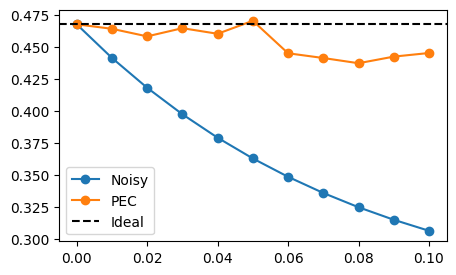

In [200]:
plt.figure(figsize=(5, 3))
plt.plot(rates_cirq, noisy_vals, 'o-', label='Noisy')
plt.plot(rates_cirq, pec_vals, 'o-', label='PEC')
plt.axhline(prob_11, color='k', linestyle='--', label='Ideal')
plt.legend()
plt.show()

In [150]:
# def execute_local_depolarizing(circ: cirq.Circuit, p_cirq):
#     circ_local_noise = circ.copy()
#     circ_local_noise = circ_local_noise.with_noise(cirq.depolarize(p_cirq))
#     return cirq.DensityMatrixSimulator().simulate(circ_local_noise).final_density_matrix[1,1].real

# noisy_vals = [execute_local_depolarizing(circ, p_cirq) for p_cirq in rates_cirq[:6]]

# pec_vals = []

# for p_cirq in tqdm(rates_cirq):
#     p = 4**n / (4**n - 1) * p_cirq
#     reps = mitiq.pec.represent_operations_in_circuit_with_local_depolarizing_noise(circ, p)
#     pec_vals.append(mitiq.pec.execute_with_pec(circ, 
#                                                partial(execute_local_depolarizing, p_cirq=p_cirq), 
#                                                representations=reps, random_state=42))


baseline: linear combination of two noisy channels: $\mathcal{E}^{-1} = \eta_1\mathcal{E}_1 - \eta_2\mathcal{E}_2$ in which both $\mathcal{E}_1$ and $\mathcal{E}_2$ are depolarizing channels (CPTP)

In [14]:
def inv_channel_rate(epsilon, n=1):
    return (4**n-1) * epsilon / (4**n-1 - 4**n * epsilon)

def decompose_inv_channel(eta_1, epsilon_inv):
    """
    The result is a relationship between epsilon_1 and epsilon_2 for subsequent manual settings for their specific values.
    """
    import sympy as sp
    # 定义未知数
    epsilon_1, epsilon_2 = sp.symbols('epsilon_1 epsilon_2')

    # 已知常数
    eta_2 = eta_1 - 1  # 例如

    # 定义方程
    eq1 = sp.Eq(eta_1 * (1 - epsilon_1) - eta_2 * (1 - epsilon_2), 1 + epsilon_inv)
    eq2 = sp.Eq(eta_1 * epsilon_1 + epsilon_inv, eta_2 * epsilon_2)

    # 求解方程组
    solutions = sp.solve((eq1, eq2), (epsilon_1, epsilon_2))

    return solutions

In [15]:
eta_1 = r // 2 # it is a heuristic super-parameter
eta_2 = eta_1 - 1

epsilon_1 = sp.symbols('epsilon_1')
epsilon_2 = sp.symbols('epsilon_2')
sol = decompose_inv_channel(eta_1, round(inv_channel_rate(p_r_cirq, 2), 10))
sol

{epsilon_1: 0.833333333333333*epsilon_2 - 0.0214585500333333}

In [16]:
p2 = 0.05
p1 = float(sol[epsilon_1].subs(epsilon_2, p2))
print(f"p1 = {p1}, p2 = {p2}")

p1 = 0.02020811663333334, p2 = 0.05


In [17]:
# verify the correctness of (eta_1, eta_2, p1, p2) -> K_inv
assert np.allclose(eta_1 * (1 - p1) - eta_2 * (1 - p2), 1 + inv_channel_rate(p_r_cirq, 2))
assert np.allclose(eta_1 * p1 - eta_2 * p2, - inv_channel_rate(p_r_cirq, 2))

channel = cirq.depolarize(p_r_cirq, 2)
super_opr = cirq.kraus_to_superoperator(cirq.protocols.kraus_protocol.kraus(channel))
super_opr_inv = np.linalg.inv(super_opr)

super_opr_1 = cirq.kraus_to_superoperator(cirq.protocols.kraus_protocol.kraus(cirq.depolarize(p1, 2)))
super_opr_2 = cirq.kraus_to_superoperator(cirq.protocols.kraus_protocol.kraus(cirq.depolarize(p2, 2)))

K_inv = (eta_1 * super_opr_1 - eta_2 * super_opr_2)

assert np.allclose(super_opr_inv, K_inv)

In [18]:
# let's do linear combination of the effect of inverse channel
circ_noise

0: ───H───@───X───X───Z^0.1───@───X^0.1───X───D(0.113)───
          │       │           │           │   │
1: ───H───X───T───@───S───────X───H───────@───#2─────────

In [19]:
circ_noise_1 = circ_noise.copy()
circ_noise_2 = circ_noise.copy()
circ_noise_1.append(cirq.depolarize(p1, 2).on(*qubits))
circ_noise_2.append(cirq.depolarize(p2, 2).on(*qubits))

In [20]:
res1 = cirq.DensityMatrixSimulator().simulate(circ_noise_1).final_density_matrix[1,1].real
res2 = cirq.DensityMatrixSimulator().simulate(circ_noise_2).final_density_matrix[1,1].real
res1, res2

(0.43714043, 0.4310624)

In [21]:
res = eta_1 * res1 - eta_2 * res2
print(prob_11, prob_11_noise, res)
print('disparity = ', res - prob_11)

0.46753024329587667 0.4412631 0.46753060817718506
disparity =  3.648813083900748e-07


In [22]:
rates_cirq_inv = np.vectorize(inv_channel_rate)(rates_cirq, 2)
print(rates_cirq)
print(rates_cirq_inv.round(4))

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
[0.     0.0101 0.0204 0.031  0.0418 0.0528 0.0641 0.0756 0.0875 0.0996
 0.1119]


In [23]:
sol[epsilon_1].as_coefficients_dict()

defaultdict(int, {1: -0.0214585500333333, epsilon_2: 0.833333333333333})

In [24]:
er_vals = []

# def extract_slope(f: sp.Add):
#     return f.as_coefficients_dict()[sp.symbols('epsilon_1')]


for p_cirq in rates_cirq:
    print('---')
    n = cirq.num_qubits(circ)
    p = 4**n / (4**n - 1) * p_cirq
    p_r = 1 - (1 - p)**r
    p_r_cirq = p_r * (4**n - 1) / 4**n
    qubits = list(circ.all_qubits())
    circ_er = circ.copy() # error-renormalizing circuit
    circ_er.append(cirq.depolarize(p_r_cirq, 2).on(*qubits))
    p_r_cirq_inv = inv_channel_rate(p_r_cirq, 2)
    # print(p_r_cirq, p_r_cirq_inv)

    eta_1 = r # it is a heuristic super-parameter
    eta_2 = eta_1 - 1

    epsilon_1 = sp.symbols('epsilon_1')
    epsilon_2 = sp.symbols('epsilon_2')
    sol = decompose_inv_channel(eta_1, round(inv_channel_rate(p_r_cirq, 2), 10))
    # print(sol)
    # extract "k" from "kx + b"
    # print(sol)
    p2 = p_r_cirq / 2 * float(sol[epsilon_1].as_coefficients_dict()[epsilon_2])
    p1 = float(sol[epsilon_1].subs(epsilon_2, p2))
    print("p_cirq = {:.2f}, p_r_cirq = {:.3f}, p1 = {:.3f}, p2 = {:.3f}".format(p_cirq, p_r_cirq, p1, p2))

    circ_noise_1 = circ_er.copy()
    circ_noise_2 = circ_er.copy()
    circ_noise_1.append(cirq.depolarize(p1, 2).on(*qubits))
    circ_noise_2.append(cirq.depolarize(p2, 2).on(*qubits))
    res1 = cirq.DensityMatrixSimulator().simulate(circ_noise_1).final_density_matrix[1,1].real
    res2 = cirq.DensityMatrixSimulator().simulate(circ_noise_2).final_density_matrix[1,1].real
    res = eta_1 * res1 - eta_2 * res2
    er_vals.append(res)


---
p_cirq = 0.00, p_r_cirq = 0.000, p1 = 0.000, p2 = 0.000
---
p_cirq = 0.01, p_r_cirq = 0.113, p1 = 0.037, p2 = 0.052
---
p_cirq = 0.02, p_r_cirq = 0.214, p1 = 0.067, p2 = 0.098
---
p_cirq = 0.03, p_r_cirq = 0.303, p1 = 0.090, p2 = 0.139
---
p_cirq = 0.04, p_r_cirq = 0.382, p1 = 0.107, p2 = 0.175
---
p_cirq = 0.05, p_r_cirq = 0.452, p1 = 0.117, p2 = 0.207
---
p_cirq = 0.06, p_r_cirq = 0.514, p1 = 0.121, p2 = 0.235
---
p_cirq = 0.07, p_r_cirq = 0.568, p1 = 0.119, p2 = 0.260
---
p_cirq = 0.08, p_r_cirq = 0.616, p1 = 0.109, p2 = 0.282
---
p_cirq = 0.09, p_r_cirq = 0.658, p1 = 0.092, p2 = 0.302
---
p_cirq = 0.10, p_r_cirq = 0.695, p1 = 0.068, p2 = 0.319


Tips:
- 增加 $\eta_1$, $\eta_2$ 能够减小 $\epsilon_1$ 和 $\epsilon_2$
- 给定 $\eta_1$, $\eta_2$ 的情况下，求解出的最终结果是 $\epsilon_1 = k_{\eta_1, \eta_2}\epsilon_2 - b_{\epsilon}$. 其中 $k_{\eta_1, \eta_2}$ only depends on $(\eta_1,\eta_2)$; $b_\epsilon > 0$ 且与 $\epsilon$ 正相关. 因此对于更大的noise level, 可以考虑增大 $\eta_1$, $\eta_2$ 以减小 $\epsilon_1$ 和 $\epsilon_2$

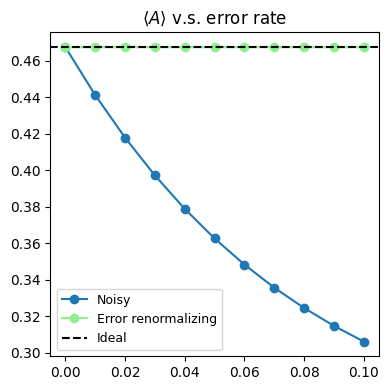

In [25]:
plt.figure(figsize=(4, 4))
plt.plot(rates_cirq, noisy_vals, 'o-', label='Noisy')
plt.plot(rates_cirq, er_vals, 'o-', label='Error renormalizing', color='lightgreen')
plt.axhline(prob_11, color='k', linestyle='--', label='Ideal')
plt.legend(fontsize=9)
plt.title(r'$\langle A \rangle$ v.s. error rate')
plt.tight_layout()
plt.savefig('circ_2q-er.pdf')
plt.show()

our end-to-end PEC method for general Pauli channel $\mathcal{E}$: 

$$
\mathcal{E}^{-1}(\cdot) = (1 + p_{\mathrm{inv}})(\cdot) - \frac{p_{\mathrm{inv}}}{4^n-1} \sum_i P_i(\cdot)P_i,\quad p_{\mathrm{inv}} = \frac{(4^n-1)p}{4^n - 1 - 4^n p} > 0 \text{ when } p < \frac{4^n - 1}{4^n}
$$

In [26]:
print(rates_cirq)
rates_cirq_inv = np.vectorize(inv_channel_rate)(rates_cirq, 2)
print(rates_cirq_inv.round(4))

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
[0.     0.0101 0.0204 0.031  0.0418 0.0528 0.0641 0.0756 0.0875 0.0996
 0.1119]


In [27]:
all_gates = list(circ.all_operations())
all_gates

[cirq.H(cirq.LineQubit(0)),
 cirq.H(cirq.LineQubit(1)),
 cirq.CNOT(cirq.LineQubit(0), cirq.LineQubit(1)),
 cirq.X(cirq.LineQubit(0)),
 cirq.T(cirq.LineQubit(1)),
 cirq.CNOT(cirq.LineQubit(1), cirq.LineQubit(0)),
 (cirq.Z**0.1).on(cirq.LineQubit(0)),
 cirq.S(cirq.LineQubit(1)),
 cirq.CNOT(cirq.LineQubit(0), cirq.LineQubit(1)),
 (cirq.X**0.1).on(cirq.LineQubit(0)),
 cirq.H(cirq.LineQubit(1)),
 cirq.CNOT(cirq.LineQubit(1), cirq.LineQubit(0))]

In [29]:
# get the quasi-probabilistic representation of all Pauli gates

from mitiq import pec
from itertools import product
from functools import reduce


In [137]:
rep = pec.represent_operation_with_local_depolarizing_noise(cirq.Circuit(cirq.X.on(qubits[0])), p_cirq)

In [139]:
rep.coeffs

[1.010135135135135,
 -0.003378378378378378,
 -0.003378378378378378,
 -0.003378378378378378]

In [140]:
print(rep)

0: ───X─── = 1.010*(0: ───X───)-0.003*(0: ───X───X───)-0.003*(0: ───X───Y───)-0.003*(0: ───X───Z───)


In [142]:
rep.basis_expansion[0]

(1.010135135135135, <mitiq.pec.types.types.NoisyOperation at 0x7fdad6b22ee0>)

In [144]:
rep.ideal

0: ───X───

In [150]:
rep.noisy_operations[1].circuit

0: ───X───X───

In [147]:
rep.coeffs

[1.010135135135135,
 -0.003378378378378378,
 -0.003378378378378378,
 -0.003378378378378378]

In [140]:
# quasi-probabilistic representation of the inverse channel

p_cirq = 0.01
p = 4**2 / (4**2 - 1) * p_cirq
p_r = 1 - (1 - p)**r
p_r_cirq = p_r * (4**2 - 1) / 4**2
print(f'p_cirq = {p_cirq}, p = {p}, p_r_cirq = {p_r_cirq}')


p_cirq = 0.01, p = 0.010666666666666666, p_r_cirq = 0.11320440490756703


In [142]:

paulis_1q = (cirq.I, cirq.X, cirq.Y, cirq.Z)
paulis = list(product(paulis_1q, repeat=2))


inv_channel_rep_ideal = [(1 + inv_channel_rate(p_r_cirq, 2), paulis[i]) if i == 0 else [- inv_channel_rate(p_r_cirq, 2) / 15, paulis[i]]  for i in range(16)]

channel = cirq.depolarize(p_r_cirq, 2)
super_opr = cirq.kraus_to_superoperator(cirq.protocols.kraus_protocol.kraus(channel))
super_opr_inv = np.linalg.inv(super_opr)

K_inv = np.zeros([4**2, 4**2]).astype(complex)
for coeff, pauli in inv_channel_rep_ideal:
    K_inv += coeff * cirq.kraus_to_superoperator([np.kron(cirq.unitary(pauli[0]), cirq.unitary(pauli[1]))])

assert np.allclose(K_inv, super_opr_inv)

inv_channel_rep = {pauli: 0 for pauli in paulis} # noisy quasi-probabilistic representation

In [143]:
def is_equiv_unitary(U: np.ndarray, V: np.ndarray) -> bool:
    """Distinguish whether two unitary operators are equivalent, regardless of the global phase."""
    if U.shape != V.shape:
        raise ValueError(f'U and V have different dimensions: {U.shape}, {V.shape}.')
    d = U.shape[0]
    if not np.allclose(U @ U.conj().T, np.identity(d)):
        raise ValueError('U is not unitary')
    if not np.allclose(V @ V.conj().T, np.identity(d)):
        raise ValueError('V is not unitary')
    Uf = U.ravel()
    Vf = V.ravel()
    idx_Uf = np.flatnonzero(Uf.round(6))  # considering some precision
    idx_Vf = np.flatnonzero(Vf.round(6))
    try:
        if np.allclose(idx_Uf, idx_Vf):
            coes = Uf[idx_Uf] / Vf[idx_Vf]
            return np.allclose(coes / coes[0], np.ones(len(idx_Uf)))
        else:
            return False
    except ValueError:
        return False

def pauli_converter(pauli1, pauli2):
    assert len(pauli1) == len(pauli2) == 2
    mat0 = cirq.unitary(pauli2[0]) @ cirq.unitary(pauli1[0])
    mat1 = cirq.unitary(pauli2[1]) @ cirq.unitary(pauli1[1])
    pauli_0, pauli_1 = cirq.I, cirq.I
    for sigma in (cirq.I, cirq.X, cirq.Y, cirq.Z):
        if is_equiv_unitary(mat0, cirq.unitary(sigma)):
            pauli_0 = sigma
        if is_equiv_unitary(mat1, cirq.unitary(sigma)):
            pauli_1 = sigma

    return pauli_0, pauli_1


In [144]:
# pauli_rep_coeffs = pec.represent_operation_with_global_depolarizing_noise(cirq.Circuit(cirq.X.on(qubits[0])), p_cirq).coeffs
pauli_rep_coeffs = pec.represent_operation_with_global_depolarizing_noise(
    cirq.Circuit(cirq.X.on(qubits[0]), cirq.X.on(qubits[1])), p_cirq
).coeffs
for eta, pauli_ideal in inv_channel_rep_ideal:
    for i, (coeff, pauli) in enumerate(zip(pauli_rep_coeffs, paulis)):
        # {coeff, pauli_ideal + pauli} is the noisy representation of pauli_ideal
        inv_channel_rep[pauli_converter(pauli_ideal, pauli)] += eta * coeff

In [145]:
inv_channel_rep

{(cirq.I, cirq.I): 1.1402472710714842,
 (cirq.I, cirq.X): -0.009349818071432368,
 (cirq.I, cirq.Y): -0.009349818071432368,
 (cirq.I, cirq.Z): -0.009349818071432368,
 (cirq.X, cirq.I): -0.00934981807143237,
 (cirq.X, cirq.X): -0.00934981807143237,
 (cirq.X, cirq.Y): -0.00934981807143237,
 (cirq.X, cirq.Z): -0.00934981807143237,
 (cirq.Y, cirq.I): -0.009349818071432371,
 (cirq.Y, cirq.X): -0.009349818071432371,
 (cirq.Y, cirq.Y): -0.009349818071432371,
 (cirq.Y, cirq.Z): -0.009349818071432371,
 (cirq.Z, cirq.I): -0.009349818071432373,
 (cirq.Z, cirq.X): -0.009349818071432373,
 (cirq.Z, cirq.Y): -0.009349818071432373,
 (cirq.Z, cirq.Z): -0.009349818071432373}

In [150]:
def coeffs_to_dist(coeffs):
    assert np.allclose(np.sum(coeffs), 1)
    gamma = np.abs(coeffs).sum()
    probs = np.abs(coeffs) / gamma
    signs = np.sign(coeffs)
    return signs, probs, gamma


def quasi_prob_sample(rep_in_pauli, precision=0.03):
    """rep_in_pauli is in dict of {pauli: coeff} format."""
    coeffs = list(rep_in_pauli.values())
    paulis = list(rep_in_pauli.keys())
    signs, probs, gamma = coeffs_to_dist(coeffs)
    num_samples = int((gamma / precision) ** 2)
    print(f'num_samples = {num_samples}, gamma = {gamma}')
    indices_sampled = np.random.choice(np.arange(len(coeffs)), num_samples, p=probs)
    return [(signs[idx], paulis[idx]) for idx in indices_sampled]

In [153]:
signs, probs, gamma = coeffs_to_dist(list(inv_channel_rep.values()))
signs, probs, gamma

(array([ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1.]),
 array([0.89047414, 0.00730172, 0.00730172, 0.00730172, 0.00730172,
        0.00730172, 0.00730172, 0.00730172, 0.00730172, 0.00730172,
        0.00730172, 0.00730172, 0.00730172, 0.00730172, 0.00730172,
        0.00730172]),
 1.2804945421429699)

In [154]:

paulis_sampled = quasi_prob_sample(inv_channel_rep)


num_samples = 1821, gamma = 1.2804945421429699


In [155]:
# vals_mosaic = []

prob_11_mosaic = 0
sampled_vals = []
for sign, pauli in tqdm(paulis_sampled):
    circ_mosaic = circ_noise.copy()
    circ_mosaic.append(pauli[0].on(qubits[0]))
    circ_mosaic.append(cirq.depolarize(p_cirq, 2).on(*qubits))
    circ_mosaic.append(pauli[1].on(qubits[1]))
    circ_mosaic.append(cirq.depolarize(p_cirq, 2).on(*qubits))
    sampled_vals.append(sign * cirq.DensityMatrixSimulator().simulate(circ_mosaic).final_density_matrix[1,1].real)

  0%|          | 0/1821 [00:00<?, ?it/s]

100%|██████████| 1821/1821 [00:12<00:00, 143.57it/s]


In [163]:

prob_11_mosaic = np.mean(sampled_vals) * gamma
disparity = abs(prob_11_mosaic - prob_11)

print(prob_11, prob_11_noise, prob_11_mosaic, disparity)


0.46753024329587667 0.4412631 0.4673970476931794 0.00013319560269725583


In [164]:
circ_mosaic

0: ───H───@───X───X───Z^0.1───@───X^0.1───X───D(0.113)───I───D(0.01)───────D(0.01)───
          │       │           │           │   │              │             │
1: ───H───X───T───@───S───────X───H───────@───#2─────────────#2────────I───#2────────

In [167]:
# end-to-end experiment with variational noisy rates
print('qubits:', qubits)
print('noise rates:', rates_cirq)
precision = 0.03


mosaic_vals = []
sampling_complexities = []
for p_cirq in rates_cirq:
    print('---')
    n = cirq.num_qubits(circ)
    p = 4**n / (4**n - 1) * p_cirq
    p_r = 1 - (1 - p)**r
    p_r_cirq = p_r * (4**n - 1) / 4**n
    print(f'p_cirq = {p_cirq:.4f}, p = {p:.4f}, p_r_cirq = {p_r_cirq:.4f}')

    circ_noise = circ.copy()
    circ_noise.append(cirq.depolarize(p_r_cirq, 2).on(*qubits))

    inv_channel_rep_ideal = [(1 + inv_channel_rate(p_r_cirq, 2), paulis[i]) if i == 0 else [- inv_channel_rate(p_r_cirq, 2) / 15, paulis[i]]  for i in range(16)]
    inv_channel_rep = {pauli: 0 for pauli in paulis} # noisy quasi-probabilistic representation
    pauli_rep_coeffs = pec.represent_operation_with_global_depolarizing_noise(
        cirq.Circuit(cirq.X.on(qubits[0]), cirq.X.on(qubits[1])), p_cirq
    ).coeffs
    for eta, pauli_ideal in inv_channel_rep_ideal:
        for i, (coeff, pauli) in enumerate(zip(pauli_rep_coeffs, paulis)):
            # {coeff, pauli_ideal + pauli} is the noisy representation of pauli_ideal
            inv_channel_rep[pauli_converter(pauli_ideal, pauli)] += eta * coeff

    signs, probs, gamma = coeffs_to_dist(list(inv_channel_rep.values()))    
    num_samples = int((gamma / precision) ** 2)
    sampling_complexities.append(num_samples)
    paulis_sampled = quasi_prob_sample(inv_channel_rep, precision=precision)

    sampled_vals = []
    for sign, pauli in tqdm(paulis_sampled):
        circ_mosaic = circ_noise.copy()
        circ_mosaic.append(pauli[0].on(qubits[0]))
        circ_mosaic.append(cirq.depolarize(p_cirq, 2).on(*qubits))
        circ_mosaic.append(pauli[1].on(qubits[1]))
        circ_mosaic.append(cirq.depolarize(p_cirq, 2).on(*qubits))
        sampled_vals.append(sign * cirq.DensityMatrixSimulator().simulate(circ_mosaic).final_density_matrix[1,1].real)

    mosaic_vals.append(np.mean(sampled_vals) * gamma)

np.save('circ_2q-mosaic_vals.npy', mosaic_vals)

qubits: [cirq.LineQubit(0), cirq.LineQubit(1)]
noise rates: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
---
p_cirq = 0.0000, p = 0.0000, p_r_cirq = 0.0000
num_samples = 1111, gamma = 1.0


100%|██████████| 1111/1111 [00:07<00:00, 142.45it/s]


---
p_cirq = 0.0100, p = 0.0107, p_r_cirq = 0.1132
num_samples = 1821, gamma = 1.2804945421429699


100%|██████████| 1821/1821 [00:13<00:00, 138.32it/s]


---
p_cirq = 0.0200, p = 0.0213, p_r_cirq = 0.2137
num_samples = 2868, gamma = 1.6066979231088223


100%|██████████| 2868/2868 [00:20<00:00, 138.04it/s]


---
p_cirq = 0.0300, p = 0.0320, p_r_cirq = 0.3029
num_samples = 4385, gamma = 1.9866836819392202


100%|██████████| 4385/4385 [00:31<00:00, 137.46it/s]


---
p_cirq = 0.0400, p = 0.0427, p_r_cirq = 0.3819
num_samples = 6561, gamma = 2.430064360168835


100%|██████████| 6561/6561 [00:47<00:00, 138.17it/s]


---
p_cirq = 0.0500, p = 0.0533, p_r_cirq = 0.4518
num_samples = 9658, gamma = 2.94830691948327


100%|██████████| 9658/9658 [01:06<00:00, 144.40it/s]


---
p_cirq = 0.0600, p = 0.0640, p_r_cirq = 0.5136
num_samples = 14043, gamma = 3.555117431661584


100%|██████████| 14043/14043 [01:39<00:00, 141.79it/s]


---
p_cirq = 0.0700, p = 0.0747, p_r_cirq = 0.5681
num_samples = 20229, gamma = 4.266911295531015


100%|██████████| 20229/20229 [02:23<00:00, 140.77it/s]


---
p_cirq = 0.0800, p = 0.0853, p_r_cirq = 0.6160
num_samples = 28938, gamma = 5.103389300147571


100%|██████████| 28938/28938 [03:23<00:00, 141.97it/s]


---
p_cirq = 0.0900, p = 0.0960, p_r_cirq = 0.6583
num_samples = 41185, gamma = 6.0882449983804205


100%|██████████| 41185/41185 [04:51<00:00, 141.48it/s]


---
p_cirq = 0.1000, p = 0.1067, p_r_cirq = 0.6953
num_samples = 58403, gamma = 7.2500353852324615


100%|██████████| 58403/58403 [07:02<00:00, 138.15it/s]


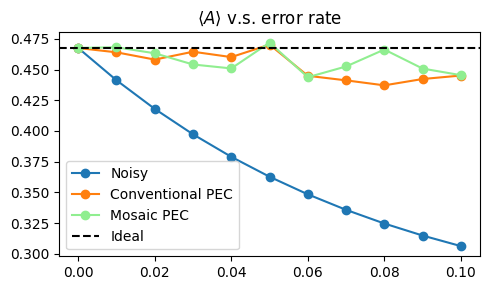

In [223]:
noisy_vals = np.load('circ_2q-noisy_vals.npy')
pec_vals = np.load('circ_2q-pec_vals.npy')
mosaic_vals = np.load('circ_2q-mosaic_vals.npy')
plt.figure(figsize=(5, 3))
plt.plot(rates_cirq, noisy_vals, 'o-', label='Noisy')
plt.plot(rates_cirq, pec_vals, 'o-', label='Conventional PEC')
plt.plot(rates_cirq, mosaic_vals, 'o-', label='Mosaic PEC', color='lightgreen')
plt.axhline(prob_11, color='k', linestyle='--', label='Ideal')
plt.legend()
plt.title(r'$\langle A \rangle$ v.s. error rate')
plt.tight_layout()
plt.savefig('circ_2q_res.pdf')
plt.show()

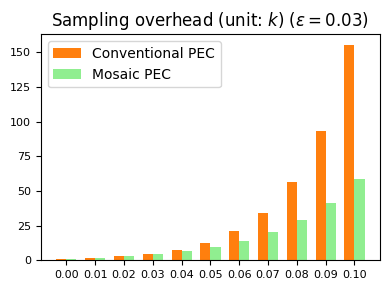

In [220]:
# sampling_complexities_pec = ...
sampling_complexities_mosaic = [1111, 1821, 2868, 4385, 6561, 9658, 14043, 20229, 28938, 41185, 58403]

# compare sampling overhead with the same precision=0.03
plt.figure(figsize=(4, 3))
x = np.arange(len(rates_cirq))
width = 0.35
plt.bar(x - width/2, np.array(sampling_complexities_pec) / 1000, width, label='Conventional PEC', color='C1')
plt.bar(x + width/2, np.array(sampling_complexities_mosaic) / 1000, width, label='Mosaic PEC', color='lightgreen')

plt.xticks(x, [f'{r:.2f}' for r in rates_cirq], fontsize=8)
plt.title('Sampling overhead (unit: $k$) ($\epsilon=0.03$)')
plt.yticks(fontsize=8)
plt.legend()
plt.tight_layout()
plt.savefig('circ_2q_sampling.pdf')
plt.show()